In [1]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import os
import json
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool, sum_models
from sklearn.utils import resample
from polimi.utils._inference import _inference
from ebrec.evaluation.metrics_protocols import *
from ebrec.utils._behaviors import sampling_strategy_wu2019
from polimi.utils._polars import reduce_polars_df_memory_size
from polimi.test.level_2_ensemble.build_model_predictions import require_subsampled_set, train_predict_model
from fastauc.fastauc.fast_auc import CppAuc
import os
import logging
from lightgbm import LGBMClassifier, LGBMRanker
from datetime import datetime
import argparse
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import List, Tuple, Dict, Type
import optuna
import polars as pl
from catboost import CatBoostClassifier, CatBoostRanker
from xgboost import XGBClassifier, XGBRanker
from polimi.utils._tuning_params import get_models_params
import gc
from polars import testing


2024-05-27 14:25:50.442129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:25:54.224979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
RANKER = False

In [3]:
level2_train_df = pl.read_parquet('/home/ubuntu/experiments/subsample_train_small_new/train_ds.parquet')

with open(os.path.join('/home/ubuntu/experiments/subsample_train_small_new', 'data_info.json')) as data_info_file:
        data_info = json.load(data_info_file)

In [4]:
level2_train_df = reduce_polars_df_memory_size(level2_train_df)
        
if 'postcode' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('article_type').fill_null('article_default'))    
if 'impression_time' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['impression_time'])               
level2_train_df = level2_train_df.to_pandas()
group_ids = level2_train_df['impression_id'].to_frame()
if 'user_id' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['user_id'])
level2_train_df = level2_train_df.drop(columns=['impression_id', 'article'])
    
X_train = level2_train_df.drop(columns=['target'])
y_train = level2_train_df['target']

del level2_train_df
gc.collect()

Memory usage of dataframe is 678.58 MB
Memory usage after optimization is: 678.58 MB
Decreased by 0.0%


/tmp/ipykernel_215280/4282822898.py:8: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_train_df = level2_train_df.drop(columns = ['impression_time'])


0

In [5]:
if RANKER:
    params = {
        'iterations': 2000,
        'depth': 8,
        'colsample_bylevel': 0.5
    }
    catboost = CatBoostRanker(**params, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, group_id=group_ids, verbose=50)
else :
    params = {
        "iterations": 1000,
        "subsample": 0.5,
        "rsm": 0.7
    }
    catboost = CatBoostClassifier(**params, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, verbose=50)

Learning rate set to 0.169254
0:	learn: 0.6433228	total: 1.2s	remaining: 19m 57s
50:	learn: 0.4902083	total: 1m 5s	remaining: 20m 15s
100:	learn: 0.4729797	total: 2m 8s	remaining: 19m 3s
150:	learn: 0.4620152	total: 3m 10s	remaining: 17m 52s
200:	learn: 0.4539098	total: 4m 12s	remaining: 16m 43s
250:	learn: 0.4474821	total: 5m 14s	remaining: 15m 37s
300:	learn: 0.4420349	total: 6m 15s	remaining: 14m 32s
350:	learn: 0.4374243	total: 7m 20s	remaining: 13m 35s
400:	learn: 0.4334085	total: 8m 24s	remaining: 12m 33s
450:	learn: 0.4298078	total: 9m 28s	remaining: 11m 32s
500:	learn: 0.4264325	total: 10m 31s	remaining: 10m 29s
550:	learn: 0.4232923	total: 11m 34s	remaining: 9m 25s
600:	learn: 0.4204146	total: 12m 36s	remaining: 8m 22s
650:	learn: 0.4178933	total: 13m 38s	remaining: 7m 18s
700:	learn: 0.4152750	total: 14m 41s	remaining: 6m 16s
750:	learn: 0.4126741	total: 15m 45s	remaining: 5m 13s
800:	learn: 0.4103542	total: 16m 45s	remaining: 4m 9s
850:	learn: 0.4080777	total: 17m 48s	remain

In [6]:
from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=data_info['categorical_columns'])
feature_importances = catboost.get_feature_importance(train_pool)

Text(0.5, 1.0, 'Catboost Feature Importances')

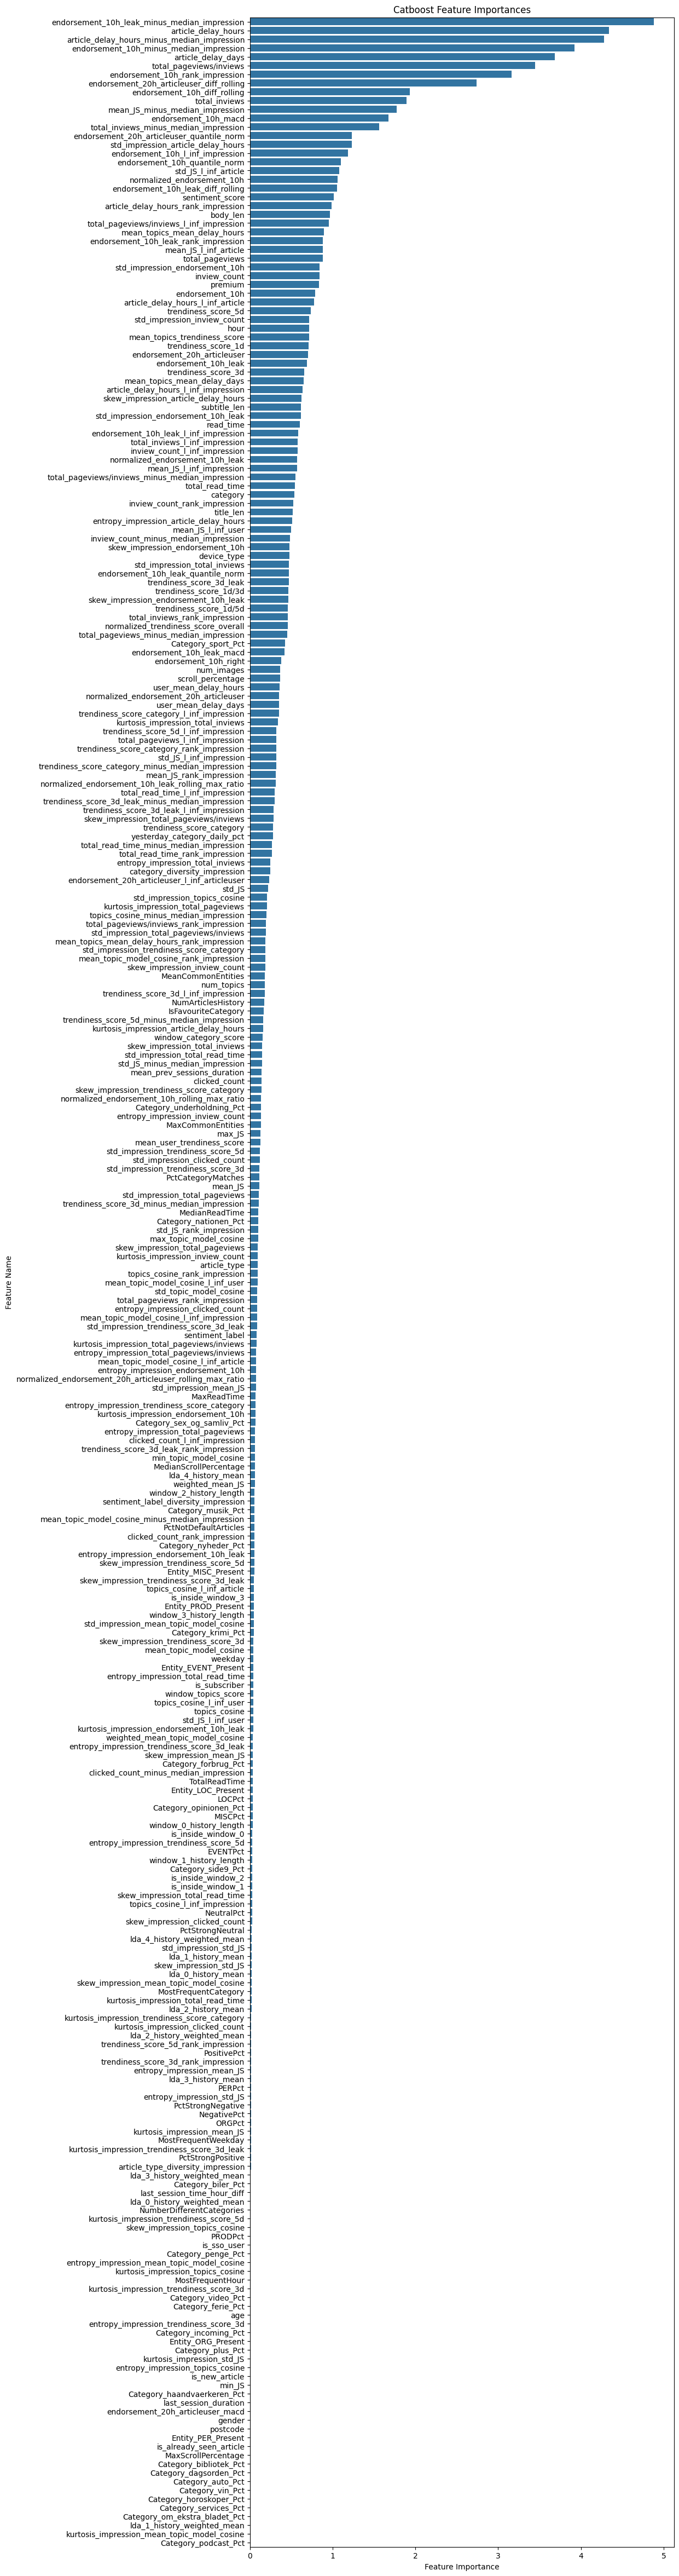

In [7]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 60))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [8]:
level2_val_df = pl.read_parquet('/home/ubuntu/experiments/subsample_validation_small_new/validation_ds.parquet')

In [9]:
if 'postcode' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('article_type').fill_null('article_default'))  
if 'impression_time' in level2_val_df.columns:
        level2_val_df = level2_val_df.drop(columns = ['impression_time']) 
        
level2_val_df = level2_val_df.to_pandas()
X_val = level2_val_df[X_train.columns]
evaluation_ds = pl.from_pandas(level2_val_df[['impression_id', 'article', 'target']])
    
if RANKER:
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict(X_val)).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
else : 
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict_proba(X_val)[:, 1]).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

/tmp/ipykernel_215280/1769437370.py:6: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_val_df = level2_val_df.drop(columns = ['impression_time'])


In [10]:
cpp_auc = CppAuc()
result = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                prediction_ds['prediction'].to_list())]
    )
print(result)

0.8042353135184033
